An End-to-End Project on Time Series Analysis and Forecasting with Python

Time series analysis comprises methods for analyzing time series data in order to extract meaningful statistics and other characteristics of the data. Time series forecasting is the use of a model to predict future values based on previously observed values.
Time series are widely used for non-stationary data, like economic, weather, stock price, and retail sales in this post. We will demonstrate different approaches for forecasting retail sales time series. Let’s get started

# The Data
# We are using Flu data that can be downloaded from here.



In [1]:
import warnings
import itertools
import os
import numpy as np
import matplotlib.pyplot as plt
#warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import pandas as pd
import statsmodels.api as sm

#matplotlib.rcParams['axes.labelsize'] = 14
#matplotlib.rcParams['xtick.labelsize'] = 12
#matplotlib.rcParams['ytick.labelsize'] = 12
#matplotlib.rcParams['text.color'] = 'k'

There are several categories in the Superstore sales data, we start from time series analysis and forecasting for furniture sales.

In [2]:
#path = 'C:/Users/shayden/Downloads/'
#os.chdir(path)
#print("Current Working Directory " , os.getcwd())

In [3]:
#National level data
dfx = pd.read_csv(r'https://raw.githubusercontent.com/jjschueder/7333QTW/master/Case%20Study%204/NationalCombined_UpTo_2020.csv')    
#Regional level data
#dfx = pd.read_csv(r'https://raw.githubusercontent.com/jjschueder/7333QTW/master/Case%20Study%204/Combined_2010_to_2020.csv')

In [4]:
dfx

,Year,Week,PositiveCases
0,1997,40,0
1,1997,41,11
2,1997,42,17
3,1997,43,7
4,1997,44,10
...,...,...,...
1180,2020,20,48
1181,2020,21,17
1182,2020,22,14
1183,2020,23,21


In [5]:
dfx.describe()

,Year,Week,PositiveCases
count,1185.000000,1185.000000,1185.000000
mean,2008.596624,26.519831,1560.747679
std,6.570896,15.142169,3653.877099
min,1997.000000,1.000000,0.000000
25%,2003.000000,13.000000,23.000000
50%,2009.000000,26.000000,207.000000
75%,2014.000000,40.000000,1173.000000
max,2020.000000,53.000000,26386.000000


In [6]:
dfx.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1185 entries, 0 to 1184
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   Year           1185 non-null   int64
 1   Week           1185 non-null   int64
 2   PositiveCases  1185 non-null   int64
dtypes: int64(3)
memory usage: 27.9 KB


In [7]:
#!python -m pip install --upgrade pandas-profiling
from pandas_profiling import ProfileReport
profile = ProfileReport(dfx, plot={'histogram': {'bins': 8}}, explorative=True)
profile.to_notebook_iframe()

In [7]:
#dropping x values for now should we impute????
#not needed anymore
dfx = dfx.loc[dfx['Year'] >= 2015]

In [8]:
# not needed anymore
#dfx['TOTAL SPECIMENS'] = dfx['TOTAL SPECIMENS'].astype(np.float64)
#dfx['PERCENT POSITIVE'] = dfx['PERCENT POSITIVE'].astype(np.float64)

In [9]:
dfx['Date'] = pd.to_datetime(dfx.Year.astype(str), format='%Y') + \
             pd.to_timedelta(dfx.Week.mul(7).astype(str) + ' days')

#dfx['PERCENT POSITIVE DEC'] = dfx['PERCENT POSITIVE'] / 100
#dfx['COUNT POSITIVE'] = dfx['TOTAL SPECIMENS'] * dfx['PERCENT POSITIVE DEC']
#created this column so the rest of the code did not need to be replaced. 
dfx['COUNT POSITIVE']=dfx['PositiveCases']

C:\Users\shayden\Anaconda3\envs\RPy\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\shayden\Anaconda3\envs\RPy\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [10]:
dfx

,Year,Week,PositiveCases,Date,COUNT POSITIVE
901,2015,1,9246,2015-01-08,9246
902,2015,2,8648,2015-01-15,8648
903,2015,3,7983,2015-01-22,7983
904,2015,4,6881,2015-01-29,6881
905,2015,5,5622,2015-02-05,5622
...,...,...,...,...,...
1180,2020,20,48,2020-05-20,48
1181,2020,21,17,2020-05-27,17
1182,2020,22,14,2020-06-03,14
1183,2020,23,21,2020-06-10,21


In [11]:
dfx['Date'].min(), dfx['Date'].max()

(Timestamp('2015-01-08 00:00:00'), Timestamp('2020-06-17 00:00:00'))

Data Preprocessing
This step includes removing columns we do not need, check missing values, aggregate sales by date and so on.

In [12]:
#cols = ['Row ID', 'Order ID', 'Ship Date', 'Ship Mode', 'Customer ID', 'Customer Name', 'Segment', 'Country', 'City', 'State', 'Postal Code', 'Region', 'Product ID', 'Category', 'Sub-Category', 'Product Name', 'Quantity', 'Discount', 'Profit']
#furniture.drop(cols, axis=1, inplace=True)
dfx = dfx.sort_values('Date')
dfx.isnull().sum()

Year              0
Week              0
PositiveCases     0
Date              0
COUNT POSITIVE    0
dtype: int64

In [13]:
dfx2 = dfx.groupby('Date')['COUNT POSITIVE'].sum().reset_index()
dfx2

,Date,COUNT POSITIVE
0,2015-01-08,9246
1,2015-01-15,8648
2,2015-01-22,7983
3,2015-01-29,6881
4,2015-02-05,5622
...,...,...
279,2020-05-20,48
280,2020-05-27,17
281,2020-06-03,14
282,2020-06-10,21


# Indexing with Time Series Data

In [14]:
dfx2 = dfx2.set_index('Date')
dfx2.index

DatetimeIndex(['2015-01-08', '2015-01-15', '2015-01-22', '2015-01-29',
               '2015-02-05', '2015-02-12', '2015-02-19', '2015-02-26',
               '2015-03-05', '2015-03-12',
               ...
               '2020-04-15', '2020-04-22', '2020-04-29', '2020-05-06',
               '2020-05-13', '2020-05-20', '2020-05-27', '2020-06-03',
               '2020-06-10', '2020-06-17'],
              dtype='datetime64[ns]', name='Date', length=284, freq=None)

Our current datetime data can be tricky to work with, therefore, we will use the averages daily sales value for that month instead, and we are using the start of each month as the timestamp.

In [15]:
#y=dfx2['COUNT POSITIVE']
#we should not use this 
y = pd.DataFrame(dfx2['COUNT POSITIVE'].resample('W').mean())
#y = pd.DataFrame(dfx2['COUNT POSITIVE'].asfreq('W-MON'))

Have a quick peek 2017 furniture sales data.

In [17]:
#y['2017':]
y.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 285 entries, 2015-01-11 to 2020-06-21
Freq: W-SUN
Data columns (total 1 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   COUNT POSITIVE  284 non-null    float64
dtypes: float64(1)
memory usage: 4.5 KB


# Visualizing Flu Cases Time Series Data

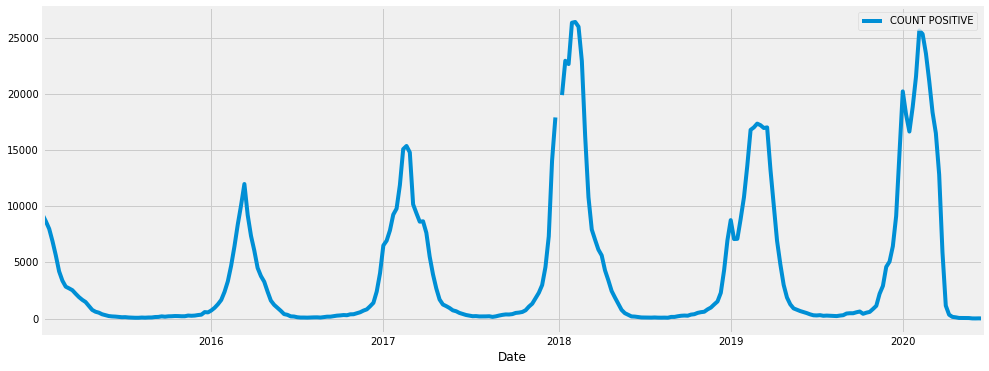

In [18]:
#import tkinter
#import matplotlib
#matplotlib.use('TkAgg')
%matplotlib inline
y.plot(figsize=(15, 6))
plt.show()

By reviewing the observations the chart, we can make a couple infancies about stattionary 
* The observations looks seasonal with peaks aligning with the new year. 
* The peaks appear to be trending upwards supporting that this in not stationary data.

We can also visualize our data using a method called time-series decomposition that allows us to decompose our time series into three distinct components: trend, seasonality, and noise.

C:\Users\shayden\Anaconda3\envs\RPy\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  This is separate from the ipykernel package so we can avoid doing imports until


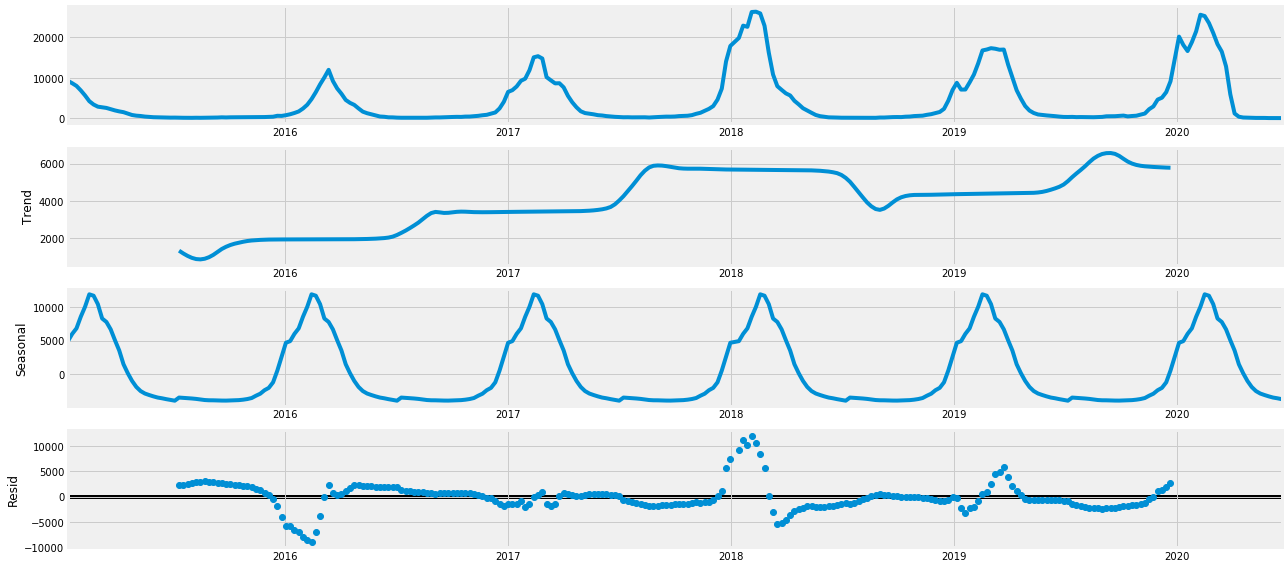

In [19]:
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(y.dropna(), model='additive',freq = 52)
fig = decomposition.plot(100)
plt.show()

#### Notes for above
* Talk about trend and the need to diffrence the data
* Talk about sesonality 
* Talk about how the residuals are not white. there seem to be a trend with them. Maybe a lag the data 



In [20]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(52).mean()
    rolstd = timeseries.rolling(52).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)


C:\Users\shayden\Anaconda3\envs\RPy\lib\site-packages\statsmodels\tsa\stattools.py:572: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  FutureWarning


Text(0.5, 1.0, 'Autocorrelation Function')

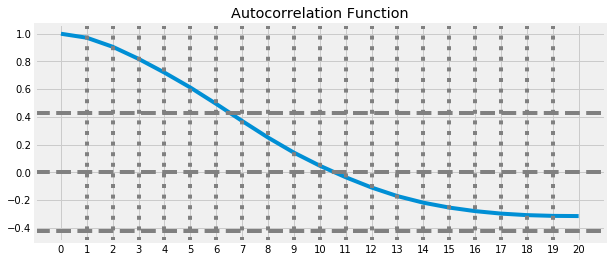

In [27]:
from statsmodels.tsa.stattools import acf, pacf
acf_dif_y = acf(y.dropna(), nlags=20)
#Plot ACF: 
plt.figure(figsize=(20, 4))

plt.subplot(121) 
plt.plot(acf_dif_y)
plt.xticks(np.arange(21))
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(acf_dif_y)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(acf_dif_y)),linestyle='--',color='gray')
for i in range(1,20):
    plt.axvline(x=i,linestyle=':',color='gray')
plt.title('Autocorrelation Function')

There appears to be serial auto correlation. Suggestion that the data may need to be differenced. We will run the dicky fuller test to check this. 

The null hypothesis of the Augmented Dickey-Fuller is that there is a unit root(it is non-stationary), with the alternative that there is no unit root. If the pvalue is above a critical size, then we cannot reject that there is a unit root.

The p-values are obtained through regression surface approximation from MacKinnon 1994, but using the updated 2010 tables. If the p-value is close to significant, then the critical values should be used to judge whether to reject the null.

If there is a unit root, there is evidence of non-stationarity data 

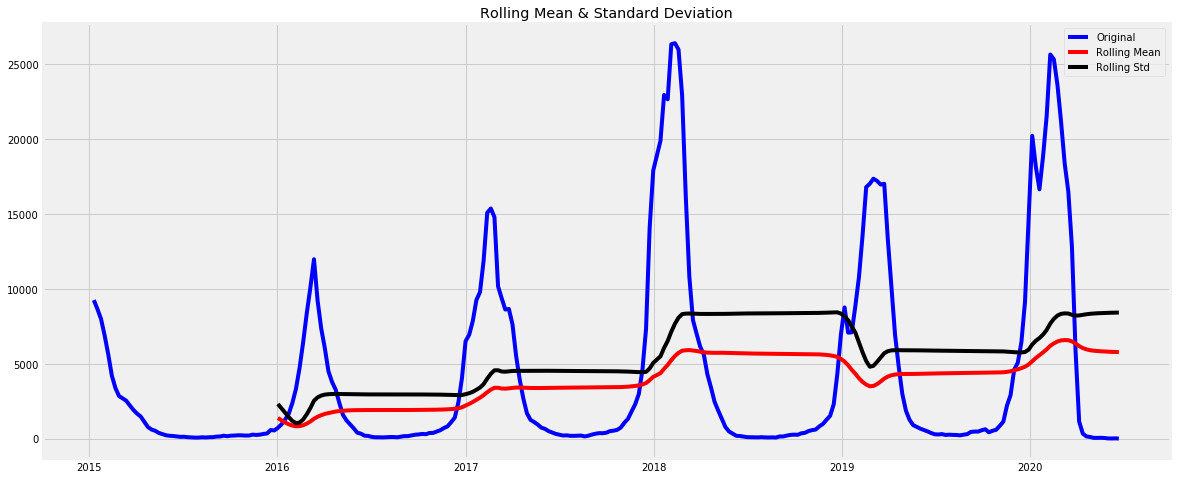

Results of Dickey-Fuller Test:
Test Statistic                  -4.917016
p-value                          0.000032
#Lags Used                       6.000000
Number of Observations Used    277.000000
Critical Value (1%)             -3.454180
Critical Value (5%)             -2.872031
Critical Value (10%)            -2.572360
dtype: float64


In [22]:
test_stationarity(y.dropna())

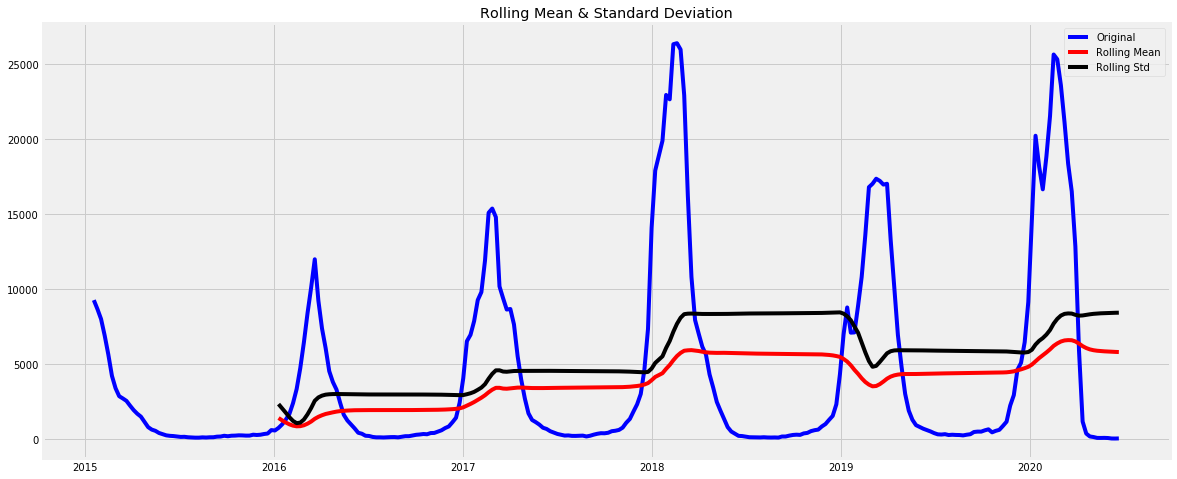

Results of Dickey-Fuller Test:
Test Statistic                  -4.915185
p-value                          0.000033
#Lags Used                       6.000000
Number of Observations Used    276.000000
Critical Value (1%)             -3.454267
Critical Value (5%)             -2.872070
Critical Value (10%)            -2.572381
dtype: float64


In [23]:
# we should diffrence the data here and fit the model on this dataset but also keep the un diffecned data 
#diff_air_pop = log_air_pop-log_air_pop.shift(1) # Changing the shift value is equivalent to changing your 'd' value
#test_stationarity(diff_air_pop.dropna())
from statsmodels.tsa.stattools import adfuller

dif_y=y.shift(1)

test_stationarity(dif_y.dropna())


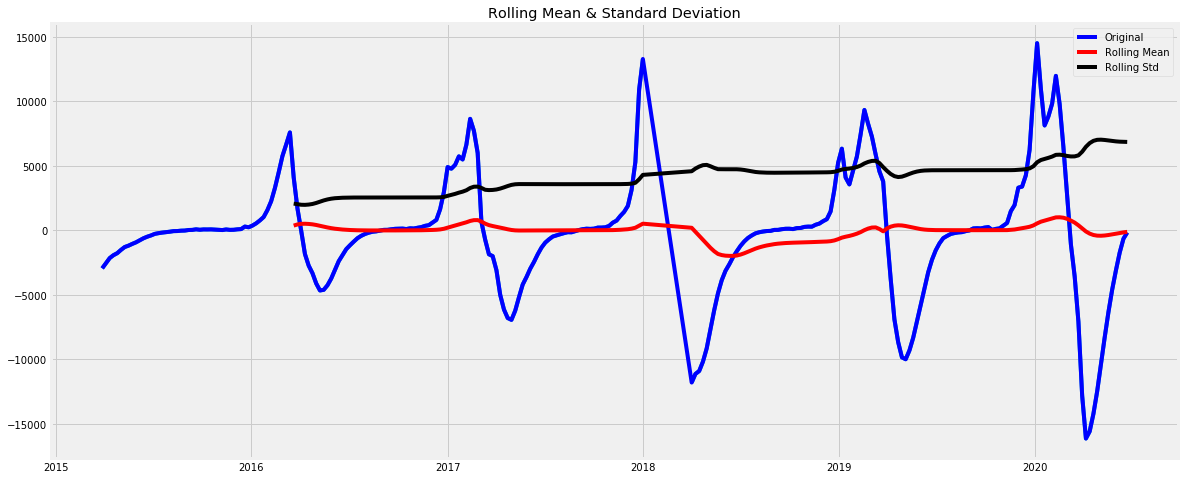

Results of Dickey-Fuller Test:
Test Statistic                -5.742272e+00
p-value                        6.235867e-07
#Lags Used                     6.000000e+00
Number of Observations Used    2.550000e+02
Critical Value (1%)           -3.456257e+00
Critical Value (5%)           -2.872942e+00
Critical Value (10%)          -2.572846e+00
dtype: float64


In [24]:
moving_avg = y.rolling(12).mean()
no_trend = y - moving_avg
plt.plot(no_trend)
plt.title("Passenger Data with Rolling Mean Removed")
test_stationarity(no_trend.dropna())

Lags in the confidence interval is good. 1 or 2 is okay, but no more. 

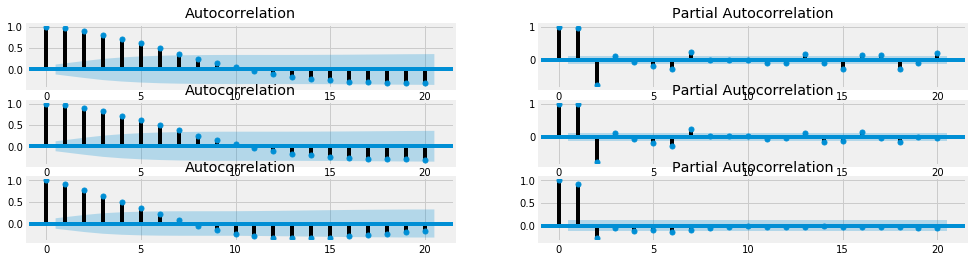

In [25]:
# Graph data
fig, axes = plt.subplots(3, 2, figsize=(15,4))

fig = sm.graphics.tsa.plot_acf(y.dropna(), lags=20, ax=axes[0,0])
fig = sm.graphics.tsa.plot_pacf(y.dropna(), lags=20, ax=axes[0,1])
fig = sm.graphics.tsa.plot_acf(dif_y.dropna(), lags=20, ax=axes[1,0])
fig = sm.graphics.tsa.plot_pacf(dif_y.dropna(), lags=20, ax=axes[1,1])
fig = sm.graphics.tsa.plot_acf(no_trend.dropna(), lags=20, ax=axes[2,0])
fig = sm.graphics.tsa.plot_pacf(no_trend.dropna(), lags=20, ax=axes[2,1])

# Time series forecasting with ARIMA
We are going to apply one of the most commonly used method for time-series forecasting, known as ARIMA, which stands for Autoregressive Integrated Moving Average.
ARIMA models are denoted with the notation ARIMA(p, d, q). These three parameters account for seasonality, trend, and noise in data:

In [118]:

# need to see if we can get this to itterate 
p = range(4, 5)
d = range(1, 2)
q = range(1, 2)

#pdq = list(itertools.permutations(p, d, q),3)
pdq = list(itertools.product(p,d,q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
#print('Examples of parameter combinations for Seasonal ARIMA...')
#print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
#print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
#print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
#print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

In [119]:
#list([list(p),list(d),list(q)])
pdq

[(4, 1, 1)]

This step is parameter Selection for our furniture’s sales ARIMA Time Series Model. Our goal here is to use a “grid search” to find the optimal set of parameters that yields the best performance for our model.



#### If simple_differencing=True, then the time series provided as endog is literally differenced and an ARMA model is fit to the resulting new time series. 

In [138]:
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(no_trend.dropna(),
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue
            
            df = pd.DataFrame('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))

C:\Users\shayden\Anaconda3\envs\RPy\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\shayden\Anaconda3\envs\RPy\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(4, 1, 1)x(4, 1, 1, 12)12 - AIC:3629.3945794995734


#ARIMA(1, 0, 1)x(1, 1, 1, 12)12 - AIC
#ARIMA(1, 0, 1)x(0, 1, 1, 12)12 - AIC	4370.278658
(0, 1, 1)x(0, 1, 1, 12

The above output suggests that SARIMAX(1, 0, 1)x(0, 1, 1, 12) yields the lowest AIC value of 4370.278658. Therefore we should consider this to be optimal option.

# Fitting the ARIMA model

In [139]:
  df

NameError: name 'df' is not defined

In [140]:
mod = sm.tsa.statespace.SARIMAX(no_trend.dropna(),
                                order=(4, 1, 1),
                                seasonal_order=(4, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

C:\Users\shayden\Anaconda3\envs\RPy\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\shayden\Anaconda3\envs\RPy\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0721      0.074     14.514      0.000       0.927       1.217
ar.L2         -0.1671      0.256     -0.653      0.514      -0.669       0.334
ar.L3         -0.0072      0.402     -0.018      0.986      -0.795       0.780
ar.L4         -0.0321      0.231     -0.139      0.890      -0.485       0.421
ma.L1         -0.9989      0.179     -5.574      0.000      -1.350      -0.648
ar.S.L12      -0.1395      0.205     -0.679      0.497      -0.542       0.263
ar.S.L24      -0.0446      0.212     -0.210      0.834      -0.461       0.372
ar.S.L36      -0.0947      0.375     -0.252      0.801      -0.831       0.641
ar.S.L48       0.0706      0.118      0.598      0.550      -0.161       0.302
ma.S.L12      -0.9446      0.262     -3.612      0.000      -1.457      -0.432
sigma2      6.272e+06   2.89e-08   2.17e+14      0.0

We should always run model diagnostics to investigate any unusual behavior.

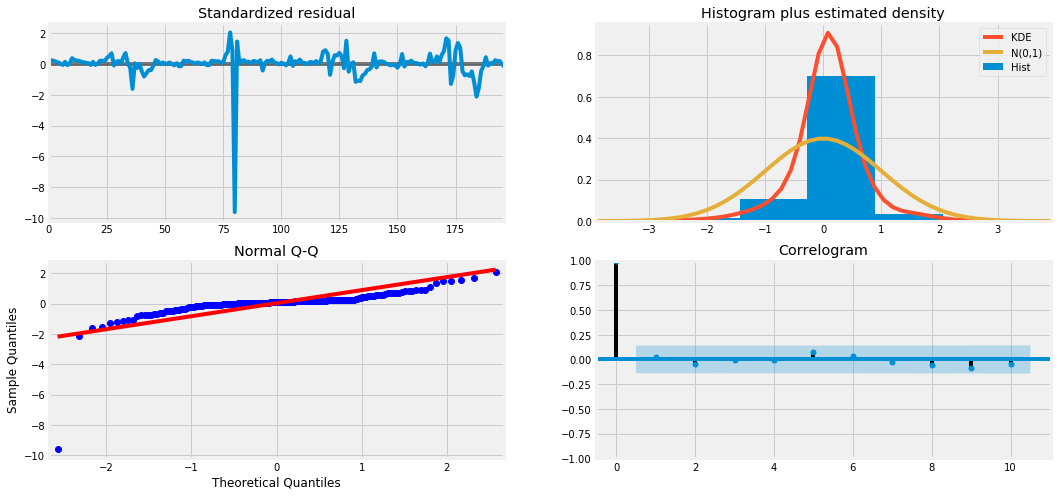

In [141]:
results.plot_diagnostics(figsize=(16, 8))
plt.show()

It is not perfect, however, our model diagnostics suggests that the model residuals are near normally distributed.

# Validating forecasts
To help us understand the accuracy of our forecasts, we compare predicted values to real values of the time series, and we set forecasts to start at 2017–01–01 to the end of the data.

,COUNT POSITIVE
Date,
2015-01-11,NaN
2015-01-18,NaN
2015-01-25,NaN
2015-02-01,NaN
2015-02-08,NaN
2015-02-15,NaN
2015-02-22,NaN
2015-03-01,NaN
2015-03-08,NaN


In [142]:
pred = results.get_prediction(start=pd.to_datetime('2019-01-01'), dynamic=False)
pred_ci = pred.conf_int()
ax = no_trend['2015':].dropna().plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Positive Cases')
plt.legend()
plt.show()

KeyError: 'The `start` argument could not be matched to a location related to the index of the data.'

The line plot is showing the observed values compared to the rolling forecast predictions. Overall, our forecasts align with the true values very well, showing an upward trend starts from the beginning of the year and captured the seasonality toward the end of the year.

In [128]:
y_forecasted = pred.predicted_mean
y_truth = y['2019-01-01':]
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

NameError: name 'pred' is not defined

In [33]:
y_forecasted - y_truth

Date
2015-01-01            NaN
2015-02-01            NaN
2015-03-01            NaN
2015-04-01            NaN
2015-05-01            NaN
                 ...     
2020-02-01   -1167.547510
2020-03-01    7017.557394
2020-04-01    3051.227922
2020-05-01   -4340.828738
2020-06-01    1645.193355
Freq: MS, Length: 66, dtype: float64

In [36]:
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Root Mean Squared Error of our forecasts is 3791.9


In statistics, the mean squared error (MSE) of an estimator measures the average of the squares of the errors — that is, the average squared difference between the estimated values and what is estimated. The MSE is a measure of the quality of an estimator — it is always non-negative, and the smaller the MSE, the closer we are to finding the line of best fit.

Root Mean Square Error (RMSE) tells us that our model was able to forecast the average weekly positive cases in the test set within **151.64 of the real sales. Our furniture daily sales range from around 400 to over 1200. In my opinion, this is a pretty good model so far.**

# Producing and visualizing forecasts

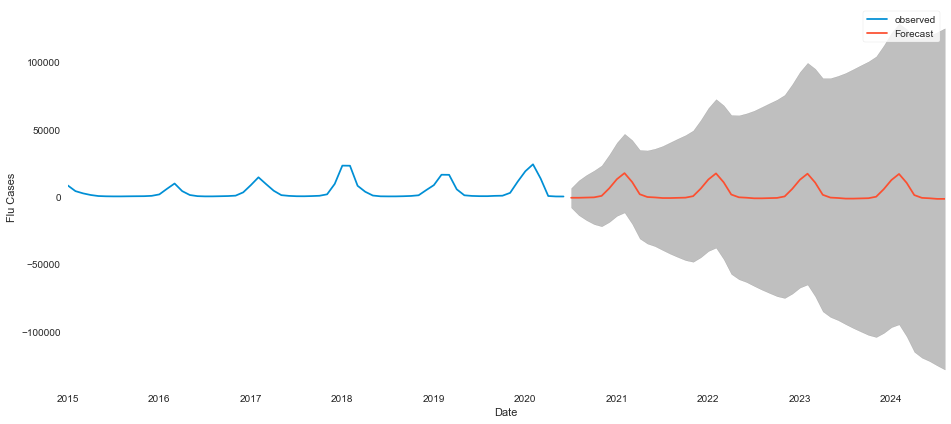

In [30]:
pred_uc = results.get_forecast(steps=50)
pred_ci = pred_uc.conf_int()
ax = y.plot(label='observed', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Flu Cases')
plt.legend()
plt.show()

Our model clearly captured furniture sales seasonality. As we forecast further out into the future, it is natural for us to become less confident in our values. This is reflected by the confidence intervals generated by our model, which grow larger as we move further out into the future.

The above time series analysis for furniture makes me curious about other categories, and how do they compare with each other over time. Therefore, we are going to compare time series of furniture and office supplier.